In [1]:
import os, sys, inspect
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib.pyplot as plt
import geoopt
import torch
import itertools
import torch.nn as nn
import numpy as np
import copy
import time

from visualutil import add_geodesic_grid
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from layers import MobiusLinear, MobiusLinearPlus, MobiusLinearFast
from layers import NetEuclidean, NetHype, NetHypePlus, NetHypeFast
from geoopt.manifolds.stereographic.math import _project, _lambda_x, tan_k, _mobius_add, tanh, sabs

%matplotlib inline

In [2]:
def train(net, optimizer, loss_func, epochs, optimizer_additional = None):
    start_time = time.time()
    net.train()
    for i in range(epochs):
        out = net(x)
        loss = loss_func(out, y)
        optimizer.zero_grad()
        if optimizer_additional is not None:
            optimizer_additional.zero_grad()

        loss.backward()
        optimizer.step()
        if optimizer_additional is not None:
            optimizer_additional.step()
        net.eval()
        if i % (epochs//10) == 0:
            prediction = torch.max(F.softmax(out, dim = 1), 1)[1]
            pred_y = prediction.detach().cpu().numpy().squeeze()
            target_y = y.detach().cpu().numpy()
            accuracy = sum(pred_y == target_y)/x.shape[0]
            print('epoch {} - accuracy: {}, loss: {}'.format(i, accuracy, loss))
        net.train()
    print("--- %s seconds ---" % (time.time() - start_time))
    # return net

In [3]:
device = 'cpu'
device = 0
if device != 'cpu':
    cudaid = "cuda:"+ str(device)
    device = torch.device(cudaid)

torch.Size([4000, 2])
torch.Size([4000])


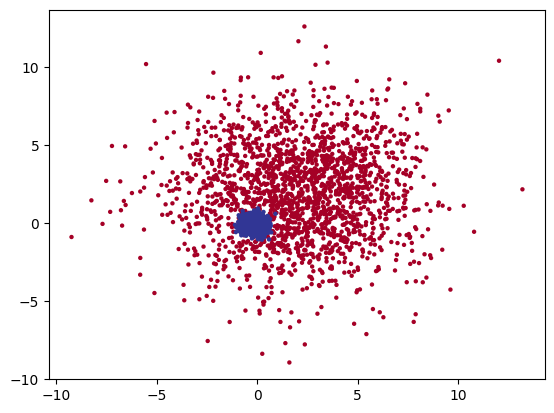

epoch 0 - accuracy: 0.55975, loss: 1.2126657962799072
epoch 50 - accuracy: 0.86775, loss: 0.5074678659439087
epoch 100 - accuracy: 0.86375, loss: 0.4812304675579071
epoch 150 - accuracy: 0.86475, loss: 0.4788825809955597
epoch 200 - accuracy: 0.866, loss: 0.47859665751457214
epoch 250 - accuracy: 0.8665, loss: 0.4785701632499695
epoch 300 - accuracy: 0.8665, loss: 0.47856855392456055
epoch 350 - accuracy: 0.8665, loss: 0.478568434715271
epoch 400 - accuracy: 0.8665, loss: 0.4785684645175934
epoch 450 - accuracy: 0.8665, loss: 0.47856849431991577
--- 0.12211441993713379 seconds ---


In [6]:
setnum = 2
total_epochs = 500

n_data = torch.ones(2000, 2)

if setnum == 1:
    x0 = torch.normal(0.9*n_data, 0.6)
    y0 = torch.zeros(n_data.shape[0])
    x1 = torch.normal(-1.2*n_data, 1.9)
    y1 = torch.ones(n_data.shape[0])

if setnum == 2:
    x0 = torch.normal(2*n_data, 3)
    y0 = torch.zeros(n_data.shape[0])
    x1 = torch.normal(-0.1*n_data, 0.3)
    y1 = torch.ones(n_data.shape[0])



x = torch.cat((x0, x1), 0).type(torch.FloatTensor).to(device)
y = torch.cat((y0, y1), ).type(torch.LongTensor).to(device)
# x = x[:,6:8]
print(x.shape)
print(y.shape)
torch.min(abs(x))

plt.scatter(x.detach().cpu().numpy()[:, 0], x.detach().cpu().numpy()[:, 1], c=y.detach().cpu().numpy(), s=10, lw=0, cmap='RdYlBu')
plt.show()

net_euc = NetEuclidean(n_feature=x.shape[1], n_output=2).to(device)
optimizer = torch.optim.Adam(net_euc.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train(net_euc, optimizer, loss_func, epochs=total_epochs)

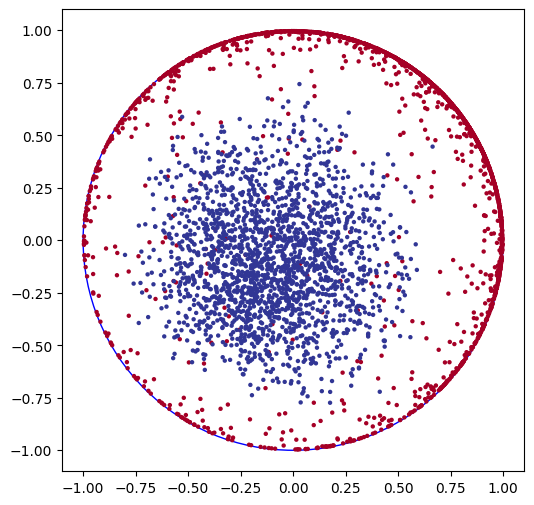

In [7]:
ball = geoopt.PoincareBall()
torch.manual_seed(42)
x = ball.expmap0(x)
x = x[:,0:2]
plt.figure(figsize=(6, 6))
circle = plt.Circle((0, 0), 1, fill=False, color="b")
# add_geodesic_grid(plt.gca(), ball, 0.5)
plt.gca().add_artist(circle)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect("equal")
plt.scatter(x.detach().cpu().numpy()[:, 0], x.detach().cpu().numpy()[:, 1], c=y.detach().cpu().numpy(), s=10, lw=0, cmap='RdYlBu')
plt.show()

In [8]:
def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired', name = ""):
    dataset_ = dataset.detach().cpu()
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = dataset_[:, 0].min() - 1, dataset_[:, 0].max() + 1
    ymin, ymax = dataset_[:, 1].min() - 1, dataset_[:, 1].max() + 1
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model_ = copy.deepcopy(model).to('cpu')
    model_.eval()
    labels_predicted = model_(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())

    # Plot decision boundary in region of interest
    labels_predicted = [0 if value[0]>=value[1] else 1 for value in labels_predicted.detach().numpy()]
    z = np.array(labels_predicted).reshape(xx.shape)
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            if xx[i, j]**2 + yy[i, j]**2 > 1:
                z[i, j] = -1
    z = np.ma.array(z, mask=z == -1)

    # Get predicted labels on training data and plot
    # train_labels_predicted = model(dataset)
    # ax.scatter(dataset[:, 0], dataset[:, 1], c=labels.reshape(labels.size()[0]), cmap=color_map, lw=0)
    plt.figure(figsize=(4, 4))
    circle = plt.Circle((0, 0), 1, fill=False, color="black")
    plt.contourf(xx, yy, z, cmap=color_map, alpha=0.4)
    # add_geodesic_grid(plt.gca(), ball, 0.5)
    plt.gca().add_artist(circle)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect("equal")
    plt.scatter(dataset_.numpy()[:, 0], dataset_.numpy()[:, 1], c=y.detach().cpu().numpy(), s=10, lw=0, cmap='RdYlBu', alpha=0.9)
    if name != "":
        plt.savefig("./savefigs/{}.pdf".format(name), dpi = 100)
    plt.show()

In [9]:
net_euc = NetEuclidean(n_feature=x.shape[1], n_output=2).to(device)
optimizer = torch.optim.Adam(net_euc.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train(net_euc, optimizer, loss_func, epochs=total_epochs)

epoch 0 - accuracy: 0.77025, loss: 0.6366670727729797
epoch 50 - accuracy: 0.8165, loss: 0.5166383385658264
epoch 100 - accuracy: 0.8205, loss: 0.48655542731285095
epoch 150 - accuracy: 0.8245, loss: 0.4793645441532135
epoch 200 - accuracy: 0.82375, loss: 0.4777296483516693
epoch 250 - accuracy: 0.8235, loss: 0.4774116575717926
epoch 300 - accuracy: 0.8235, loss: 0.47736138105392456
epoch 350 - accuracy: 0.8235, loss: 0.4773551821708679
epoch 400 - accuracy: 0.82325, loss: 0.47735464572906494
epoch 450 - accuracy: 0.82325, loss: 0.47735461592674255
--- 0.11939811706542969 seconds ---


In [10]:
net_hype = NetHype(n_feature=x.shape[1], n_output=2).to(device)
optimizer = geoopt.optim.RiemannianAdam(net_hype.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train(net_hype, optimizer, loss_func, epochs=total_epochs)

epoch 0 - accuracy: 0.51025, loss: 0.7403019666671753
epoch 50 - accuracy: 0.79025, loss: 0.5514909625053406
epoch 100 - accuracy: 0.86275, loss: 0.46337831020355225
epoch 150 - accuracy: 0.88925, loss: 0.42422589659690857
epoch 200 - accuracy: 0.895, loss: 0.4078429341316223
epoch 250 - accuracy: 0.89775, loss: 0.3980028033256531
epoch 300 - accuracy: 0.89775, loss: 0.391261488199234
epoch 350 - accuracy: 0.898, loss: 0.38641616702079773
epoch 400 - accuracy: 0.89875, loss: 0.3828076124191284
epoch 450 - accuracy: 0.89875, loss: 0.38004884123802185
--- 2.3309333324432373 seconds ---


In [11]:
net_hype_plus = NetHypePlus(n_feature=x.shape[1], n_output=2).to(device)
optimizer = geoopt.optim.RiemannianAdam(net_hype_plus.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train(net_hype_plus, optimizer, loss_func, epochs=total_epochs)

epoch 0 - accuracy: 0.31025, loss: 0.9978948831558228
epoch 50 - accuracy: 0.7505, loss: 0.5637814998626709
epoch 100 - accuracy: 0.88575, loss: 0.46328768134117126
epoch 150 - accuracy: 0.91575, loss: 0.4256066679954529
epoch 200 - accuracy: 0.933, loss: 0.40375518798828125
epoch 250 - accuracy: 0.93525, loss: 0.3950091004371643
epoch 300 - accuracy: 0.935, loss: 0.3908696174621582
epoch 350 - accuracy: 0.936, loss: 0.3883123993873596
epoch 400 - accuracy: 0.939, loss: 0.3854626417160034
epoch 450 - accuracy: 0.94, loss: 0.3830527067184448
--- 0.5649199485778809 seconds ---


In [12]:
net_hype_fast = NetHypeFast(n_feature=x.shape[1], n_output=2).to(device)
optimizer = torch.optim.Adam(net_hype_fast.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train(net_hype_fast, optimizer, loss_func, epochs=total_epochs)

epoch 0 - accuracy: 0.57525, loss: 0.5992012619972229
epoch 50 - accuracy: 0.97125, loss: 0.4241117835044861
epoch 100 - accuracy: 0.96725, loss: 0.3547849953174591
epoch 150 - accuracy: 0.96775, loss: 0.3387832045555115
epoch 200 - accuracy: 0.9685, loss: 0.3286789655685425
epoch 250 - accuracy: 0.969, loss: 0.3212989866733551
epoch 300 - accuracy: 0.9695, loss: 0.3156200647354126
epoch 350 - accuracy: 0.97, loss: 0.31107938289642334
epoch 400 - accuracy: 0.97025, loss: 0.3073408007621765
epoch 450 - accuracy: 0.9705, loss: 0.30419108271598816
--- 0.37911462783813477 seconds ---


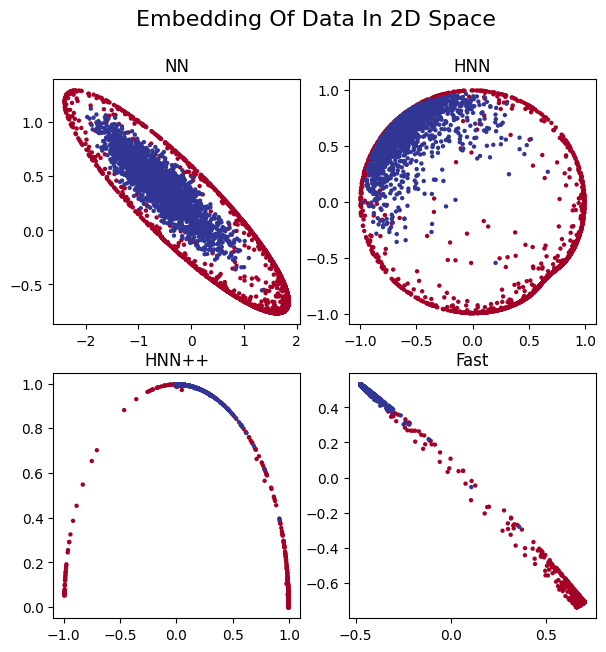

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
out = net_euc(x)
out = out.detach().cpu().numpy()
ax[0,0].scatter(out[:,0], out[:,1], c = y.detach().cpu().numpy(), s=10, lw=0, cmap='RdYlBu')
ax[0,0].set_title('NN')
out = net_hype(x)
out = out.detach().cpu().numpy()
ax[0,1].scatter(out[:,0], out[:,1], c = y.detach().cpu().numpy(), s=10, lw=0, cmap='RdYlBu')
ax[0,1].set_title('HNN')
out = net_hype_plus(x)
out = out.detach().cpu().numpy()
ax[1,0].scatter(out[:,0], out[:,1], c = y.detach().cpu().numpy(), s=10, lw=0, cmap='RdYlBu')
ax[1,0].set_title('HNN++')
out = net_hype_fast(x)
out = out.detach().cpu().numpy()
ax[1,1].scatter(out[:,0], out[:,1], c = y.detach().cpu().numpy(), s=10, lw=0, cmap='RdYlBu')
ax[1,1].set_title('Fast')
fig.suptitle('Embedding Of Data In 2D Space', fontsize=16)
plt.show()

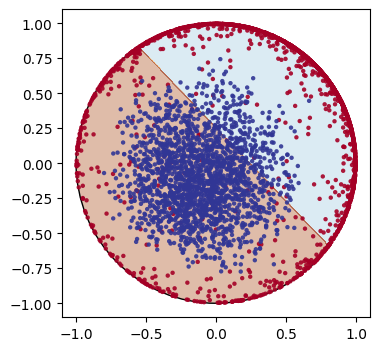

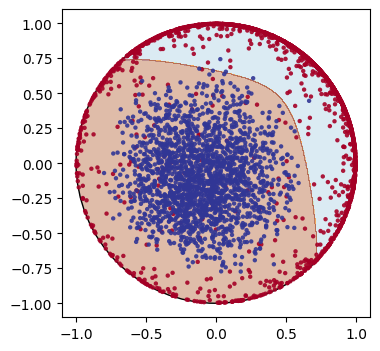

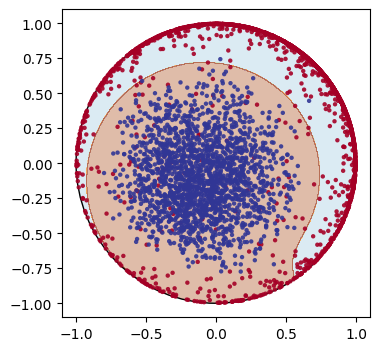

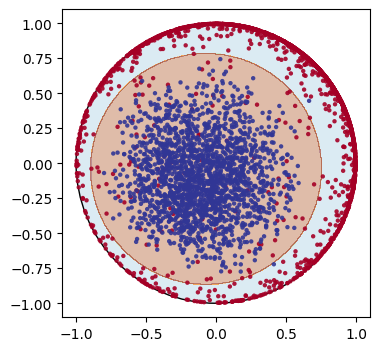

In [15]:
savefig = False
plot_decision_boundary(x, y, net_euc, steps=1000, name="euc-{}".format(setnum) if savefig else "") # Euclidean MLP
plot_decision_boundary(x, y, net_hype, steps=1000, name="hmlp-{}".format(setnum) if savefig else "") # Hyperbolic MLP
plot_decision_boundary(x, y, net_hype_plus, steps=1000, name="hfc-{}".format(setnum) if savefig else "") # Poincare FC Layer (HNN++, Shimizu)
plot_decision_boundary(x, y, net_hype_fast, steps=1000, name="propose-{}".format(setnum) if savefig else "") # proposed